<a href="https://colab.research.google.com/github/VladislavasR/PP5/blob/main/PP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start of the PP5

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from IPython.display import Markdown, display

import tensorflow as tf
tf.__version__

'2.8.2'

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import math
import matplotlib.animation as animation
from tensorflow import keras
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model

In [ ]:
!wget https://raw.githubusercontent.com/VladislavasR/PP4/main/electricity_prices.csv

--2022-09-06 20:04:59--  https://raw.githubusercontent.com/VladislavasR/PP4/main/electricity_prices.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4048368 (3.9M) [text/plain]
Saving to: ‘electricity_prices.csv.4’

electricity_prices. 100%[===================>]   3.86M  --.-KB/s    in 0.07s   

2022-09-06 20:04:59 (53.0 MB/s) - ‘electricity_prices.csv.4’ saved [4048368/4048368]



In [ ]:
el_prices = pd.read_csv('electricity_prices.csv')
el_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DateTime                38014 non-null  object
 1   Holiday                 38014 non-null  object
 2   HolidayFlag             38014 non-null  int64 
 3   DayOfWeek               38014 non-null  int64 
 4   WeekOfYear              38014 non-null  int64 
 5   Day                     38014 non-null  int64 
 6   Month                   38014 non-null  int64 
 7   Year                    38014 non-null  int64 
 8   PeriodOfDay             38014 non-null  int64 
 9   ForecastWindProduction  38014 non-null  object
 10  SystemLoadEA            38014 non-null  object
 11  SMPEA                   38014 non-null  object
 12  ORKTemperature          38014 non-null  object
 13  ORKWindspeed            38014 non-null  object
 14  CO2Intensity            38014 non-null  object
 15  Ac

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,10,11,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
el_prices = el_prices.replace('?', np.NaN)
el_prices['DateTime']=pd.to_datetime(el_prices['DateTime'], dayfirst=True)

In [ ]:
# columns_to_numeric columns changes every time colab is restarted. Need to update which columns change to numeric on every load.
columns_to_numeric = ['ForecastWindProduction', 'SystemLoadEA', 'SMPEA', 'ORKTemperature', 'ORKWindspeed', 'CO2Intensity', 'ActualWindProduction', 'SystemLoadEP2', 'SMPEP2']
el_prices[columns_to_numeric] = el_prices[columns_to_numeric].apply(pd.to_numeric)

In [ ]:
el_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38014 entries, 0 to 38013
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   DateTime                38014 non-null  datetime64[ns]
 1   Holiday                 38014 non-null  object        
 2   HolidayFlag             38014 non-null  int64         
 3   DayOfWeek               38014 non-null  int64         
 4   WeekOfYear              38014 non-null  int64         
 5   Day                     38014 non-null  int64         
 6   Month                   38014 non-null  int64         
 7   Year                    38014 non-null  int64         
 8   PeriodOfDay             38014 non-null  int64         
 9   ForecastWindProduction  38009 non-null  float64       
 10  SystemLoadEA            38012 non-null  float64       
 11  SMPEA                   38012 non-null  float64       
 12  ORKTemperature          37719 non-null  float6

In [ ]:
el_prices = el_prices.dropna()

In [ ]:
y = el_prices.SMPEP2
X_clean = el_prices[['SMPEA','SystemLoadEP2','SystemLoadEA', 'PeriodOfDay']]

In [ ]:
def normalize(arr):
  return (arr - arr.mean()) / arr.std()

y_norm = normalize(y)
X_norm = normalize(X_clean)

In [ ]:
inputs = Input(shape=(4,))
preds = Dense(1,activation='linear')(inputs)
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='mse', metrics=['mse'])
model.fit(X_norm, y_norm, batch_size=10, epochs=10, verbose=1)

Epoch 1/10
3769/3769 [==============================] - 8s 2ms/step - loss: 0.6061 - mse: 0.6061
Epoch 2/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5745 - mse: 0.5745
Epoch 3/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5723 - mse: 0.5723
Epoch 4/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5741 - mse: 0.5741
Epoch 5/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5757 - mse: 0.5757
Epoch 6/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5756 - mse: 0.5756
Epoch 7/10
3769/3769 [==============================] - 8s 2ms/step - loss: 0.5746 - mse: 0.5746
Epoch 8/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5751 - mse: 0.5751
Epoch 9/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.5726 - mse: 0.5726
Epoch 10/10
3769/3769 [==============================] - 8s 2ms/step - loss: 0.5725 - mse: 0.5725


In [ ]:
inputs = Input(shape=(4,))
preds = Dense(1,activation='relu')(inputs)
model = Model(inputs=inputs, outputs=preds)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss='mse', metrics=['mse'])
model.fit(X_norm, y_norm, batch_size=10, epochs=10, verbose=1)

Epoch 1/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6975 - mse: 0.6975
Epoch 2/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6836 - mse: 0.6836
Epoch 3/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6804 - mse: 0.6804
Epoch 4/10
3769/3769 [==============================] - 7s 2ms/step - loss: 0.6788 - mse: 0.6788
Epoch 5/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6787 - mse: 0.6787
Epoch 6/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6794 - mse: 0.6794
Epoch 7/10
3769/3769 [==============================] - 8s 2ms/step - loss: 0.6788 - mse: 0.6788
Epoch 8/10
3769/3769 [==============================] - 9s 2ms/step - loss: 0.6808 - mse: 0.6808
Epoch 9/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6784 - mse: 0.6784
Epoch 10/10
3769/3769 [==============================] - 6s 2ms/step - loss: 0.6789 - mse: 0.6789


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.3, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(1, input_shape=(4,), activation='linear'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(Adam(learning_rate=0.05), 'mse', metrics=['mse'])

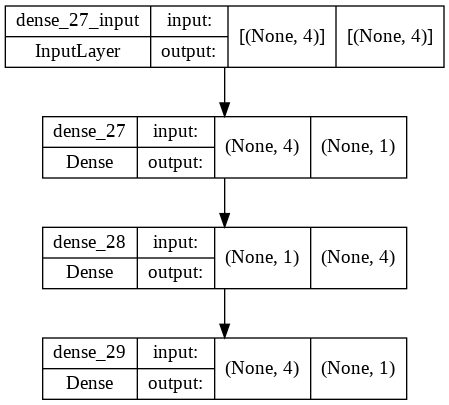

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

my_callbacks = [EarlyStopping(monitor='mse', patience=5, mode='max')]
model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test, y_test))

Epoch 1/20
825/825 [==============================] - 2s 3ms/step - loss: 0.7587 - mse: 0.7587 - val_loss: 0.8158 - val_mse: 0.8158
Epoch 2/20
825/825 [==============================] - 2s 3ms/step - loss: 0.7583 - mse: 0.7583 - val_loss: 0.8167 - val_mse: 0.8167
Epoch 3/20
825/825 [==============================] - 2s 3ms/step - loss: 0.7576 - mse: 0.7576 - val_loss: 0.8189 - val_mse: 0.8189
Epoch 4/20
825/825 [==============================] - 2s 3ms/step - loss: 0.7578 - mse: 0.7578 - val_loss: 0.8146 - val_mse: 0.8146
Epoch 5/20
825/825 [==============================] - 2s 2ms/step - loss: 0.7578 - mse: 0.7578 - val_loss: 0.8136 - val_mse: 0.8136
Epoch 6/20
825/825 [==============================] - 2s 3ms/step - loss: 0.7575 - mse: 0.7575 - val_loss: 0.8163 - val_mse: 0.8163
Epoch 7/20
825/825 [==============================] - 2s 3ms/step - loss: 0.7583 - mse: 0.7583 - val_loss: 0.8146 - val_mse: 0.8146
Epoch 8/20
825/825 [==============================] - 2s 3ms/step - loss: 0.